In [3]:
import os
from stardist.models import StarDist2D 
from stardist import random_label_cmap
from tifffile import imread, imsave
from csbdeep.utils import normalize
import cv2
from skimage import img_as_float32, img_as_ubyte
import pandas as pd
import numpy as np
from scipy.interpolate import RegularGridInterpolator

def video_interpolation(video, factor, spatial_factor = 1, method = "linear"):
    
    # Factor: the number by which the size is divided (donwscale by a factor of 2 means factor = 2)
    
    # Indexes of x, y, z coordinates of the current image
    x_old = np.linspace(0, (video.shape[1]-1), video.shape[1])
    y_old = np.linspace(0, (video.shape[2]-1), video.shape[2])
    z_old = np.arange(0, (video.shape[0]))
    print("Initial frame number = ", video.shape[0])
    
    # define the interpolating object
    interpolating_object = RegularGridInterpolator((z_old, x_old, y_old), video, method=method, bounds_error=False)
    
    # Corresponding coordinates for the new image.
    # For example position, the position 1 with a downsampling of factor of 2, has position 0.5
    x_new = np.round(video.shape[1]/spatial_factor).astype('int')
    y_new = np.round(video.shape[2]/spatial_factor).astype('int')
    z_new = np.arange(z_old[0], z_old[-1], factor)

    # pts is the new grid
    pts = np.indices((len(z_new), x_new, y_new)).transpose((1, 2, 3, 0))
    pts = pts.reshape(1, len(z_new)*x_new*y_new, 1, 3).reshape(len(z_new)*x_new*y_new, 3)
    pts = np.array(pts, dtype=float)
    pts[:, 1:3] = pts[:, 1:3]*spatial_factor
    pts[:, 0] = pts[:, 0]*factor +z_new[0]

    print("Total frame number = ", pts.shape[0]/(video.shape[1]*video.shape[2]))

    # Interpolate
    interpolated_data = interpolating_object(pts)
    interpolated_data = interpolated_data.reshape(len(z_new), x_new, y_new)
    return interpolated_data


def segment_stack(path, model, average_t=False):
    timelapse = imread(path)
    # normalize channels independently
    
    if len(timelapse.shape)==2:
        timelapse = normalize(timelapse, 1,99.8, axis=(0,1))
        print(f'The image {path} is not a stack and will be processed individually')
        labels, polygons = model.predict_instances(timelapse)  
        prediction_stack = labels
    else:
        axis_norm = (0,1) 
        if average_t:
            factor = 2 ## downsampling factor
            timelapse = video_interpolation(timelapse, factor)
        timelapse = normalize(timelapse, 1,99.8, axis=(0,)+tuple(1+np.array(axis_norm)))
        n_timepoint = timelapse.shape[0]
        prediction_stack = []

        for t in range(n_timepoint):
            labels, polygons = model.predict_instances(timelapse[t])      
            prediction_stack.append(labels)
        prediction_stack = np.array(prediction_stack)

    return(prediction_stack)

                
                
def process_folder(input_path, output_path, model, average_t=False):
    folders = os.listdir(input_path)
    os.makedirs(output_path, exist_ok=True)
    for f in folders:
        print(os.path.join(input_path, f))
        if f[0] != '.':
            if not f.__contains__("videos_real_A"):
                if not f.__contains__('.'):
                    os.makedirs(os.path.join(output_path, f), exist_ok=True)
                    process_folder(os.path.join(input_path, f), os.path.join(output_path, f), model, average_t=average_t)
                elif f.__contains__('.tif'):
                    mask = segment_stack(os.path.join(input_path, f), model, average_t=average_t)
                    imsave(os.path.join(output_path, f), mask.astype(np.uint16))
                    


In [4]:
input_path = "/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing"
output_path = "/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/STARDIST/CHO-SYNCHRO/missing"

Prediction_model_folder = "/home/ocb/HardDrive_4TB/EGM/PHX/PhotoFITT/notebooks/deep-learning/StarDist/pretrained_models/2D_versatile_fluo" #@param {type:"string"}
#Here we find the loaded model name and parent path
Prediction_model_name = os.path.basename(Prediction_model_folder)
Prediction_model_path = os.path.dirname(Prediction_model_folder)

model = StarDist2D(None, name = Prediction_model_name, basedir = Prediction_model_path)

process_folder(input_path, output_path, model, average_t=True)

2024-05-21 16:57:18.392727: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-21 16:57:18.462848: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230503_475_night
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230503_475_night/Individual
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230503_475_night/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230503_475_night/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230503_475_night/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B
/media/ocb/OCB-Data2/PhotoFiTT/PIX2P

1752810688.py (85): <tifffile.imsave> is deprecated. Use tifffile.imwrite


/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230503_475_night/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_475__live-02-Scene-03-P8-A01.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230503_475_night/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_475__live-02-Scene-03-P8-A01.tif is not a stack and will be processed individually
1/1 [==============================] - 0s 158ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230503_475_night/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_475__live-02-Scene-04-P7-A01.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230503_475_night/Individual/pix2pix_ch

1/1 [==============================] - 0s 154ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230503_475_night/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_475__live-02-Scene-17-P8-A02.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230503_475_night/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_475__live-02-Scene-17-P8-A02.tif is not a stack and will be processed individually
1/1 [==============================] - 0s 159ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230503_475_night/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_475__live-02-Scene-18-P4-A02.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYN

1/1 [==============================] - 0s 152ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230503_475_night/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_475__live-02-Scene-31-P4-A04.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230503_475_night/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_475__live-02-Scene-31-P4-A04.tif is not a stack and will be processed individually
1/1 [==============================] - 0s 149ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230503_475_night/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_475__live-02-Scene-32-P9-A04.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYN

1/1 [==============================] - 0s 159ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230503_475_night/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_475__live-02-Scene-45-P9-B04.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230503_475_night/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_475__live-02-Scene-45-P9-B04.tif is not a stack and will be processed individually
1/1 [==============================] - 0s 151ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230503_475_night/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_475__live-02-Scene-46-P10-B04.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SY

1/1 [==============================] - 0s 155ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230503_475_night/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_475__live-02-Scene-59-P10-B03.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230503_475_night/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_475__live-02-Scene-59-P10-B03.tif is not a stack and will be processed individually
1/1 [==============================] - 0s 151ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230503_475_night/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_475__live-02-Scene-60-P1-B03.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-S

1/1 [==============================] - 0s 155ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230503_475_night/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_475__live-02-Scene-73-P3-B01.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230503_475_night/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_475__live-02-Scene-73-P3-B01.tif is not a stack and will be processed individually
1/1 [==============================] - 0s 152ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230503_475_night/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_475__live-02-Scene-74-P5-B01.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYN

1/1 [==============================] - 0s 153ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230504_568_night_630-rename/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_630__live-02-Scene-05-P10-A01.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230504_568_night_630-rename/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_630__live-02-Scene-05-P10-A01.tif is not a stack and will be processed individually
1/1 [==============================] - 0s 151ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230504_568_night_630-rename/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_630__live-02-Scene-06-P5-A01.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SIN

1/1 [==============================] - 0s 157ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230504_568_night_630-rename/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_630__live-02-Scene-18-P9-A02.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230504_568_night_630-rename/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_630__live-02-Scene-18-P9-A02.tif is not a stack and will be processed individually
1/1 [==============================] - 0s 157ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230504_568_night_630-rename/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_630__live-02-Scene-19-P4-A02.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGL

1/1 [==============================] - 0s 156ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230504_568_night_630-rename/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_630__live-02-Scene-31-P4-A04.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230504_568_night_630-rename/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_630__live-02-Scene-31-P4-A04.tif is not a stack and will be processed individually
1/1 [==============================] - 0s 152ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230504_568_night_630-rename/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_630__live-02-Scene-32-P9-A04.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGL

1/1 [==============================] - 0s 156ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230504_568_night_630-rename/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_630__live-02-Scene-44-P7-B04.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230504_568_night_630-rename/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_630__live-02-Scene-44-P7-B04.tif is not a stack and will be processed individually
1/1 [==============================] - 0s 152ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230504_568_night_630-rename/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_630__live-02-Scene-45-P9-B04.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGL

1/1 [==============================] - 0s 153ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230504_568_night_630-rename/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_630__live-02-Scene-57-P5-B03.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230504_568_night_630-rename/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_630__live-02-Scene-57-P5-B03.tif is not a stack and will be processed individually
1/1 [==============================] - 0s 157ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230504_568_night_630-rename/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_630__live-02-Scene-58-P10-B03.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SING

1/1 [==============================] - 0s 153ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230504_568_night_630-rename/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_630__live-02-Scene-70-P10-B02.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230504_568_night_630-rename/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_630__live-02-Scene-70-P10-B02.tif is not a stack and will be processed individually
1/1 [==============================] - 0s 159ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230504_568_night_630-rename/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_630__live-02-Scene-71-P1-B01.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SIN

1/1 [==============================] - 0s 153ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230505_475_day/individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_475_live-01-Scene-02-P7-A01.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230505_475_day/individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_475_live-01-Scene-02-P7-A01.tif is not a stack and will be processed individually
1/1 [==============================] - 0s 152ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230505_475_day/individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_475_live-01-Scene-03-P5-A01.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/miss

1/1 [==============================] - 0s 154ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230505_475_day/individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_475_live-01-Scene-16-P1-A02.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230505_475_day/individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_475_live-01-Scene-16-P1-A02.tif is not a stack and will be processed individually
1/1 [==============================] - 0s 151ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230505_475_day/individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_475_live-01-Scene-17-P8-A02.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/miss

1/1 [==============================] - 0s 157ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230505_475_day/individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_475_live-01-Scene-30-P1-A03.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230505_475_day/individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_475_live-01-Scene-30-P1-A03.tif is not a stack and will be processed individually
1/1 [==============================] - 0s 158ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230505_475_day/individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_475_live-01-Scene-31-P4-A04.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/miss

1/1 [==============================] - 0s 156ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230505_475_day/individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_475_live-01-Scene-44-P5-B04.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230505_475_day/individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_475_live-01-Scene-44-P5-B04.tif is not a stack and will be processed individually
1/1 [==============================] - 0s 152ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230505_475_day/individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_475_live-01-Scene-45-P10-B04.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/mis

1/1 [==============================] - 0s 159ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230505_475_day/individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_475_live-01-Scene-58-P2-B03.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230505_475_day/individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_475_live-01-Scene-58-P2-B03.tif is not a stack and will be processed individually
1/1 [==============================] - 0s 151ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230505_475_day/individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_475_live-01-Scene-59-P5-B03.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/miss

1/1 [==============================] - 0s 161ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230505_475_day/individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_475_live-01-Scene-72-P7-B01.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230505_475_day/individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_475_live-01-Scene-72-P7-B01.tif is not a stack and will be processed individually
1/1 [==============================] - 0s 162ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230505_475_day/individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_475_live-01-Scene-73-P5-B01.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/miss

1/1 [==============================] - 0s 153ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230504_630_day/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_630__live-02-Scene-05-P10-A01.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230504_630_day/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_630__live-02-Scene-05-P10-A01.tif is not a stack and will be processed individually
1/1 [==============================] - 0s 158ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230504_630_day/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_630__live-02-Scene-06-P5-A01.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO

1/1 [==============================] - 0s 153ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230504_630_day/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_630__live-02-Scene-19-P4-A02.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230504_630_day/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_630__live-02-Scene-19-P4-A02.tif is not a stack and will be processed individually
1/1 [==============================] - 0s 152ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230504_630_day/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_630__live-02-Scene-20-P3-A02.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/m

1/1 [==============================] - 0s 161ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230504_630_day/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_630__live-02-Scene-33-P6-A04.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230504_630_day/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_630__live-02-Scene-33-P6-A04.tif is not a stack and will be processed individually
1/1 [==============================] - 0s 155ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230504_630_day/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_630__live-02-Scene-34-P3-A04.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/m

1/1 [==============================] - 0s 151ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230504_630_day/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_630__live-02-Scene-47-P2-B04.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230504_630_day/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_630__live-02-Scene-47-P2-B04.tif is not a stack and will be processed individually
1/1 [==============================] - 0s 152ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230504_630_day/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_630__live-02-Scene-48-P5-B04.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/m

1/1 [==============================] - 0s 158ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230504_630_day/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_630__live-02-Scene-61-P4-B02.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230504_630_day/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_630__live-02-Scene-61-P4-B02.tif is not a stack and will be processed individually
1/1 [==============================] - 0s 150ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230504_630_day/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_630__live-02-Scene-62-P5-B02.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/m

1/1 [==============================] - 0s 156ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230504_630_day/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_630__live-02-Scene-75-P4-B01.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230504_630_day/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_630__live-02-Scene-75-P4-B01.tif is not a stack and will be processed individually
1/1 [==============================] - 0s 161ms/step
/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing/20230504_630_day/Individual/pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024/test_latest/videos_fake_B/CHO_day_630__live-02-Scene-76-P2-B01.tif
The image /media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/m

# PREPARE VIRTUAL STAINING FOR STARDIST

In [48]:
import cv2
from tifffile import imsave

def frames2videos_pix2pix(path2im):
    path2real = os.path.join(path2im, "images_real_A")
    path2fake = os.path.join(path2im, "images_fake_B")
    
    files = os.listdir(path2real)
    
    video_names = [i.split("_0000_")[0] for i in files if i.__contains__("_0000_")]
    
    path2real_reconstructions = os.path.join(path2im, "videos_real_A")
    path2fake_reconstructions = os.path.join(path2im, "videos_fake_B")
    os.makedirs(path2real_reconstructions, exist_ok=True)
    os.makedirs(path2fake_reconstructions, exist_ok=True)
    for v in video_names:
        video = [j for j in files if j.__contains__(v)]
        video.sort()
        real_video = []
        fake_video = []
        
        for j in video:
            real_video.append(cv2.imread(os.path.join(path2real, j))[...,0])
            fake_filename = j.split("_real_A.png")[0] + "_fake_B.png"
            
            fake_video.append(cv2.imread(os.path.join(path2fake, fake_filename))[...,0])
        real_video = np.array(real_video)
        fake_video = np.array(fake_video)
        imsave(os.path.join(path2real_reconstructions, f"{v}.tif"), real_video)
        imsave(os.path.join(path2fake_reconstructions, f"{v}.tif"), fake_video)
        print(f"{v} processed")


def digest_predictions(Result_folder):
    folders = os.listdir(Result_folder)
    folders.sort
    print(folders)
    if "images_fake_B" in folders:
        frames2videos_pix2pix(Result_folder)
    else:
        for f in folders:
            if f[0] != '.':
                digest_predictions(os.path.join(Result_folder, f))

digest_predictions("/media/ocb/20E49F1D420A62A0/PhotoFiTT/PIX2PIX-labelling/HELA-SYNCH/2022-10-20_day/")

['Individual']
['test_latest']
['images_fake_B', 'images_real_A', 'index.html', 'videos_fake_B', 'videos_real_A']


/tmp/ipykernel_2829541/169028993.py:29: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave(os.path.join(path2real_reconstructions, f"{v}.tif"), real_video)
/tmp/ipykernel_2829541/169028993.py:30: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave(os.path.join(path2fake_reconstructions, f"{v}.tif"), fake_video)


HeLa_UV-live-01-Scene-01-P3-A01 processed
HeLa_UV-live-01-Scene-02-P2-A01 processed
HeLa_UV-live-01-Scene-03-P1-A01 processed
HeLa_UV-live-01-Scene-04-P9-A01 processed
HeLa_UV-live-01-Scene-70-P9-B02 processed
HeLa_UV-live-01-Scene-05-P7-A01 processed
HeLa_UV-live-01-Scene-06-P10-A01 processed
HeLa_UV-live-01-Scene-08-P4-A01 processed
HeLa_UV-live-01-Scene-07-P5-A01 processed
HeLa_UV-live-01-Scene-09-P6-A01 processed
HeLa_UV-live-01-Scene-10-P8-A01 processed
HeLa_UV-live-01-Scene-11-P2-A02 processed
HeLa_UV-live-01-Scene-12-P10-A02 processed
HeLa_UV-live-01-Scene-15-P4-A02 processed
HeLa_UV-live-01-Scene-13-P3-A02 processed
HeLa_UV-live-01-Scene-16-P6-A02 processed
HeLa_UV-live-01-Scene-17-P5-A02 processed
HeLa_UV-live-01-Scene-18-P1-A02 processed
HeLa_UV-live-01-Scene-19-P8-A02 processed
HeLa_UV-live-01-Scene-20-P9-A02 processed
HeLa_UV-live-01-Scene-21-P4-A03 processed
HeLa_UV-live-01-Scene-22-P1-A03 processed
HeLa_UV-live-01-Scene-23-P3-A03 processed
HeLa_UV-live-01-Scene-24-P8-A03 

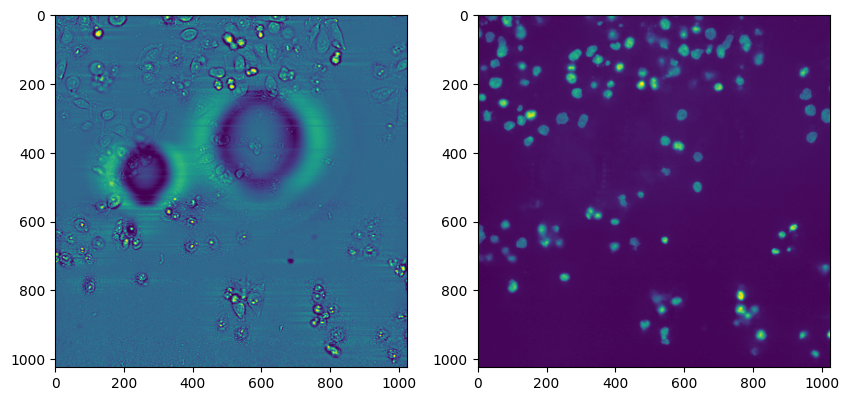

In [28]:
fake = "/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/HELA-SYNCHRO-nuclei/2022-10-19_night/Individual/test_latest/videos_fake_B/HeLa_UV-live-01-Scene-69-P10-B02.tif"
real = "/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/HELA-SYNCHRO-nuclei/2022-10-19_night/Individual/test_latest/videos_real_A/HeLa_UV-live-01-Scene-69-P10-B02.tif"


import cv2
im = tifffile.imread(fake)
im = im[45]
im_real = tifffile.imread(real)
im_real = im_real[45]
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 20))
plt.subplot(1,2,1)
plt.imshow(im_real)
plt.subplot(1,2,2)
plt.imshow(im)
plt.show()

In [1]:
import os
import tifffile
import numpy as np

def extract_single_frame(input_folder, output_folder, frames=3, t0 = 0):
    files = [f for f in os.listdir(input_folder) if f.endswith(".tif")]
    os.makedirs(output_folder, exist_ok=True)
    print("Processing...")
    for f in files:
        im = tifffile.imread(os.path.join(input_folder, f))
        im = im[t0:t0 + frames]
        im = np.squeeze(np.max(im, axis=0))
        tifffile.imwrite(os.path.join(output_folder, f), im)
    print(f'Folder {input_folder} done.')


def prepare_virtual_staining(input_dir, output_dir, frames=3, t0 = 0):
    os.makedirs(output_dir, exist_ok=True)
    for f in os.listdir(input_dir):
        valid = [np.int8(f.startswith(i)) for i in [".", "images_", "index.html", "rejected", "comparison", "videos_real_A"]]
        if np.sum(valid)==0:
            print(f'Processing {f}')
            if f.endswith(".tif"):
                im = tifffile.imread(os.path.join(input_dir, f))
                im = im[:frames]
                im = np.squeeze(np.max(im, axis=0))
                tifffile.imwrite(os.path.join(output_dir, f), im)
            else:
                prepare_virtual_staining(os.path.join(input_dir, f), os.path.join(output_dir, f), frames=frames, t0 = t0)
                print(f'{f} done.')



input_dir = "/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/CHO-SYNCHRO-nuclei/missing/"
output_dir = "/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/VIRTUAL-STAINING/CHO-SYNCHRO/missing"
prepare_virtual_staining(input_dir, output_dir, frames=2, t0 = 1)


Processing 20230503_475_night
Processing Individual
Processing pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024
Processing test_latest
Processing videos_fake_B
Processing CHO_day_475__live-02-Scene-01-P3-A01.tif
Processing CHO_day_475__live-02-Scene-02-P1-A01.tif
Processing CHO_day_475__live-02-Scene-03-P8-A01.tif
Processing CHO_day_475__live-02-Scene-04-P7-A01.tif
Processing CHO_day_475__live-02-Scene-05-P6-A01.tif
Processing CHO_day_475__live-02-Scene-06-P2-A01.tif
Processing CHO_day_475__live-02-Scene-07-P10-A01.tif
Processing CHO_day_475__live-02-Scene-08-P5-A01.tif
Processing CHO_day_475__live-02-Scene-09-P4-A01.tif
Processing CHO_day_475__live-02-Scene-10-P9-A01.tif
Processing CHO_day_475__live-02-Scene-11-P5-A02.tif
Processing CHO_day_475__live-02-Scene-12-P6-A02.tif
Processing CHO_day_475__live-02-Scene-13-P1-A02.tif
Processing CHO_day_475__live-02-Scene-14-P7-A02.tif
Processing CHO_day_475__live-02-Scene-15-P2-A02.tif
Processing CHO_day_475__live-02-Scene-16-P9-A0

Processing CHO_day_630__live-02-Scene-69-P8-B02.tif
Processing CHO_day_630__live-02-Scene-70-P10-B02.tif
Processing CHO_day_630__live-02-Scene-71-P1-B01.tif
Processing CHO_day_630__live-02-Scene-72-P7-B01.tif
Processing CHO_day_630__live-02-Scene-73-P3-B01.tif
Processing CHO_day_630__live-02-Scene-74-P5-B01.tif
Processing CHO_day_630__live-02-Scene-75-P4-B01.tif
Processing CHO_day_630__live-02-Scene-76-P2-B01.tif
Processing CHO_day_630__live-02-Scene-77-P9-B01.tif
Processing CHO_day_630__live-02-Scene-78-P8-B01.tif
Processing CHO_day_630__live-02-Scene-79-P10-B01.tif
Processing CHO_day_630__live-02-Scene-80-P6-B01.tif
videos_fake_B done.
test_latest done.
pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024 done.
Individual done.
20230504_568_night_630-rename done.
Processing 20230505_475_day
Processing individual
Processing pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024
Processing test_latest
Processing videos_fake_B
Processing CHO_day_475_live-01-Scene-01-P6-A

Processing CHO_day_630__live-02-Scene-64-P3-B02.tif
Processing CHO_day_630__live-02-Scene-65-P6-B02.tif
Processing CHO_day_630__live-02-Scene-66-P7-B02.tif
Processing CHO_day_630__live-02-Scene-67-P2-B02.tif
Processing CHO_day_630__live-02-Scene-68-P9-B02.tif
Processing CHO_day_630__live-02-Scene-69-P8-B02.tif
Processing CHO_day_630__live-02-Scene-70-P10-B02.tif
Processing CHO_day_630__live-02-Scene-71-P1-B01.tif
Processing CHO_day_630__live-02-Scene-72-P7-B01.tif
Processing CHO_day_630__live-02-Scene-73-P3-B01.tif
Processing CHO_day_630__live-02-Scene-74-P5-B01.tif
Processing CHO_day_630__live-02-Scene-75-P4-B01.tif
Processing CHO_day_630__live-02-Scene-76-P2-B01.tif
Processing CHO_day_630__live-02-Scene-77-P9-B01.tif
Processing CHO_day_630__live-02-Scene-78-P8-B01.tif
Processing CHO_day_630__live-02-Scene-79-P10-B01.tif
Processing CHO_day_630__live-02-Scene-80-P6-B01.tif
videos_fake_B done.
test_latest done.
pix2pix_cho_selectedz_nuclei_ph_contrast_resized1024_18012024 done.
Individu